In [1]:
%load_ext autoreload
%autoreload 2


import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'


In [2]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

In [3]:
from torchsummary import summary
import torch
use_cuda=torch.cuda.is_available()
import pytorch
from pytorch import dataset as ptd

import os
import datasets
import pytorch_models
import torch.optim as optim
dataset_name="cifar10"
(x_train, y_train), (x_test, y_test), input_shape,num_classes = datasets.get_data(dataset_name)
dataset=ptd.ClassificationDataset(dataset_name,x_train,x_test,y_train,y_test,num_classes,input_shape)

print('x_train shape:', x_train.shape,x_train.dtype)
print('x_test shape:', x_test.shape,x_test.dtype)
print('y_train shape:', y_train.shape,y_train.dtype)
print('y_test shape:', y_test.shape,y_test.dtype)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


import numpy as np
print(np.unique(y_train.argmax(axis=1)))
print(y_train.min(),y_train.max())


Using TensorFlow backend.
/home/facundo/.python/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


x_train shape: (50000, 32, 32, 3) uint8
x_test shape: (10000, 32, 32, 3) uint8
y_train shape: (50000, 10) float64
y_test shape: (10000, 10) float64
50000 train samples
10000 test samples
[0 1 2 3 4 5 6 7 8 9]
0.0 1.0


In [4]:
from pytorch import training

import pytorch_models

conv_filters={"mnist":32,"mnist_rot":32,"cifar10":64}
fc_filters={"mnist":64,"mnist_rot":64,"cifar10":128}
model = pytorch_models.SimpleConv(input_shape,num_classes,
                                 conv_filters=conv_filters[dataset.name],fc_filters=fc_filters[dataset.name])
#model= pytorch_models.FFNet(input_shape,num_classes)x
if use_cuda:
    model=model.cuda()
parameters=training.add_weight_decay(model.named_parameters(),1e-9)
optimizer = optim.Adam(parameters, lr=0.001)
print(model)

rotated_model= pytorch_models.SimpleConv(input_shape,num_classes,
                                       conv_filters=conv_filters[dataset.name],fc_filters=fc_filters[dataset.name])
if use_cuda:
    rotated_model= rotated_model.cuda()
rotated_parameters=training.add_weight_decay(rotated_model.named_parameters(),1e-9)
rotated_optimizer = optim.Adam(rotated_parameters, lr=0.001)

print(rotated_model)
#summary(model, input_size=[1,28,28])


SimpleConv(
  (conv): SequentialWithIntermediates(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
  )
  (fc): SequentialWithIntermediates(
    (0): Linear(in_features=16384, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)
SimpleConv(
  (conv): SequentialWithIntermediates(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1)

Training model with unrotated dataset...


Epoch 1: 100% (batch 782/782)  ==stats==> loss:   1.35, accuracy:  0.507, Time:  0:00:12


Test => Loss: 1.0069, Accuracy: 64.23% (6423/10000)


Epoch 2: 100% (batch 782/782)  ==stats==> loss:  0.844, accuracy:    0.7, Time:  0:00:12


Test => Loss: 0.8561, Accuracy: 69.70% (6970/10000)


Epoch 3: 100% (batch 782/782)  ==stats==> loss:  0.624, accuracy:  0.783, Time:  0:00:12


Test => Loss: 0.7002, Accuracy: 76.12% (7612/10000)


Epoch 4: 100% (batch 782/782)  ==stats==> loss:   0.47, accuracy:  0.835, Time:  0:00:12


Test => Loss: 0.6956, Accuracy: 76.93% (7693/10000)


Epoch 5: 100% (batch 782/782)  ==stats==> loss:  0.336, accuracy:  0.882, Time:  0:00:11


Test => Loss: 0.7580, Accuracy: 77.71% (7771/10000)


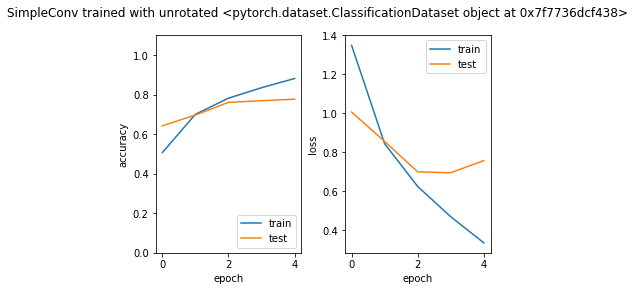

Skipping pretraining rotated model with unrotated dataset
Training rotated model with rotated dataset...


Epoch 1: 100% (batch 782/782)  ==stats==> loss:   1.84, accuracy:  0.324, Time:  0:00:12


Test => Loss: 1.6649, Accuracy: 39.83% (3983/10000)


Epoch 2: 100% (batch 782/782)  ==stats==> loss:   1.57, accuracy:  0.435, Time:  0:00:12


Test => Loss: 1.4641, Accuracy: 46.80% (4680/10000)


Epoch 3: 100% (batch 782/782)  ==stats==> loss:   1.44, accuracy:  0.478, Time:  0:00:12


Test => Loss: 1.3838, Accuracy: 50.29% (5029/10000)


Epoch 4: 100% (batch 782/782)  ==stats==> loss:   1.34, accuracy:  0.519, Time:  0:00:12


Test => Loss: 1.3139, Accuracy: 52.97% (5297/10000)


Epoch 5: 100% (batch 782/782)  ==stats==> loss:   1.26, accuracy:  0.549, Time:  0:00:12


Test => Loss: 1.2351, Accuracy: 55.96% (5596/10000)


Epoch 6: 100% (batch 782/782)  ==stats==> loss:    1.2, accuracy:  0.568, Time:  0:00:12


Test => Loss: 1.1952, Accuracy: 57.71% (5771/10000)


Epoch 7: 100% (batch 782/782)  ==stats==> loss:   1.15, accuracy:  0.587, Time:  0:00:12


Test => Loss: 1.1416, Accuracy: 59.68% (5968/10000)


Epoch 8: 100% (batch 782/782)  ==stats==> loss:   1.11, accuracy:  0.604, Time:  0:00:12


Test => Loss: 1.1477, Accuracy: 59.78% (5978/10000)


Epoch 9: 100% (batch 782/782)  ==stats==> loss:   1.08, accuracy:  0.619, Time:  0:00:12


Test => Loss: 1.0961, Accuracy: 61.18% (6118/10000)


Epoch 10: 100% (batch 782/782)  ==stats==> loss:   1.06, accuracy:  0.628, Time:  0:00:12


Test => Loss: 1.0836, Accuracy: 61.49% (6149/10000)


Epoch 11: 100% (batch 782/782)  ==stats==> loss:   1.03, accuracy:  0.638, Time:  0:00:12


Test => Loss: 1.0566, Accuracy: 62.84% (6284/10000)


Epoch 12: 100% (batch 782/782)  ==stats==> loss:   1.01, accuracy:  0.643, Time:  0:00:12


Test => Loss: 1.0458, Accuracy: 63.44% (6344/10000)


Epoch 13: 100% (batch 782/782)  ==stats==> loss:  0.993, accuracy:  0.647, Time:  0:00:12


Test => Loss: 1.0200, Accuracy: 64.33% (6433/10000)


Epoch 14: 100% (batch 782/782)  ==stats==> loss:  0.977, accuracy:  0.653, Time:  0:00:12


Test => Loss: 1.0331, Accuracy: 63.81% (6381/10000)


Epoch 15: 100% (batch 782/782)  ==stats==> loss:  0.962, accuracy:   0.66, Time:  0:00:12


Test => Loss: 1.0352, Accuracy: 63.63% (6363/10000)


Epoch 16: 100% (batch 782/782)  ==stats==> loss:  0.944, accuracy:  0.668, Time:  0:00:12


Test => Loss: 0.9905, Accuracy: 65.48% (6548/10000)


Epoch 17: 100% (batch 782/782)  ==stats==> loss:  0.933, accuracy:  0.669, Time:  0:00:12


Test => Loss: 1.0140, Accuracy: 64.93% (6493/10000)


Epoch 18: 100% (batch 782/782)  ==stats==> loss:  0.914, accuracy:  0.677, Time:  0:00:12


Test => Loss: 0.9786, Accuracy: 65.86% (6586/10000)


Epoch 19: 100% (batch 782/782)  ==stats==> loss:  0.907, accuracy:  0.681, Time:  0:00:12


Test => Loss: 1.0035, Accuracy: 65.68% (6568/10000)


Epoch 20: 100% (batch 782/782)  ==stats==> loss:  0.895, accuracy:  0.686, Time:  0:00:12


Test => Loss: 0.9627, Accuracy: 66.56% (6656/10000)


Epoch 21: 100% (batch 782/782)  ==stats==> loss:  0.886, accuracy:  0.689, Time:  0:00:12


Test => Loss: 0.9764, Accuracy: 66.66% (6666/10000)


Epoch 22: 100% (batch 782/782)  ==stats==> loss:  0.877, accuracy:  0.692, Time:  0:00:12


Test => Loss: 0.9426, Accuracy: 67.21% (6721/10000)


Epoch 23: 100% (batch 782/782)  ==stats==> loss:  0.875, accuracy:  0.691, Time:  0:00:12


Test => Loss: 0.9854, Accuracy: 65.34% (6534/10000)


Epoch 24: 100% (batch 782/782)  ==stats==> loss:  0.862, accuracy:  0.696, Time:  0:00:12


Test => Loss: 0.9519, Accuracy: 67.00% (6700/10000)


Epoch 25: 100% (batch 782/782)  ==stats==> loss:  0.854, accuracy:    0.7, Time:  0:00:12


Test => Loss: 0.9485, Accuracy: 67.16% (6716/10000)


Epoch 26: 100% (batch 782/782)  ==stats==> loss:  0.852, accuracy:  0.702, Time:  0:00:12


Test => Loss: 0.9509, Accuracy: 67.38% (6738/10000)


Epoch 27: 100% (batch 782/782)  ==stats==> loss:  0.831, accuracy:  0.708, Time:  0:00:12


Test => Loss: 0.9546, Accuracy: 67.00% (6700/10000)


Epoch 28: 100% (batch 782/782)  ==stats==> loss:  0.835, accuracy:  0.709, Time:  0:00:12


Test => Loss: 0.9240, Accuracy: 67.69% (6769/10000)


Epoch 29: 100% (batch 782/782)  ==stats==> loss:  0.825, accuracy:  0.712, Time:  0:00:12


Test => Loss: 0.9464, Accuracy: 67.76% (6776/10000)


Epoch 30: 100% (batch 782/782)  ==stats==> loss:   0.82, accuracy:  0.712, Time:  0:00:12


Test => Loss: 0.9542, Accuracy: 67.08% (6708/10000)


Epoch 31: 100% (batch 782/782)  ==stats==> loss:  0.816, accuracy:  0.713, Time:  0:00:12


Test => Loss: 0.9366, Accuracy: 67.79% (6779/10000)


Epoch 32: 100% (batch 782/782)  ==stats==> loss:  0.809, accuracy:  0.716, Time:  0:00:12


Test => Loss: 0.9429, Accuracy: 67.74% (6774/10000)


Epoch 33: 100% (batch 782/782)  ==stats==> loss:  0.806, accuracy:  0.718, Time:  0:00:12


Test => Loss: 0.9184, Accuracy: 68.62% (6862/10000)


Epoch 34: 100% (batch 782/782)  ==stats==> loss:  0.796, accuracy:  0.721, Time:  0:00:12


Test => Loss: 0.9288, Accuracy: 68.50% (6850/10000)


Epoch 35: 100% (batch 782/782)  ==stats==> loss:  0.789, accuracy:  0.725, Time:  0:00:12


Test => Loss: 0.9244, Accuracy: 68.38% (6838/10000)


Epoch 36: 100% (batch 782/782)  ==stats==> loss:  0.794, accuracy:  0.723, Time:  0:00:12


Test => Loss: 0.9312, Accuracy: 67.58% (6758/10000)


Epoch 37: 100% (batch 782/782)  ==stats==> loss:  0.784, accuracy:  0.725, Time:  0:00:12


Test => Loss: 0.9302, Accuracy: 68.10% (6810/10000)


Epoch 38: 100% (batch 782/782)  ==stats==> loss:  0.777, accuracy:  0.729, Time:  0:00:12


Test => Loss: 0.9218, Accuracy: 68.40% (6840/10000)


Epoch 39: 100% (batch 782/782)  ==stats==> loss:  0.774, accuracy:  0.727, Time:  0:00:12


Test => Loss: 0.9266, Accuracy: 68.39% (6839/10000)


Epoch 40: 100% (batch 782/782)  ==stats==> loss:  0.773, accuracy:   0.73, Time:  0:00:12


Test => Loss: 0.9363, Accuracy: 68.38% (6838/10000)


Epoch 41: 100% (batch 782/782)  ==stats==> loss:   0.77, accuracy:  0.732, Time:  0:00:12


Test => Loss: 0.9062, Accuracy: 69.00% (6900/10000)


Epoch 42: 100% (batch 782/782)  ==stats==> loss:  0.754, accuracy:  0.739, Time:  0:00:12


Test => Loss: 0.9359, Accuracy: 67.94% (6794/10000)


Epoch 43: 100% (batch 782/782)  ==stats==> loss:  0.754, accuracy:  0.736, Time:  0:00:12


Test => Loss: 0.9252, Accuracy: 68.61% (6861/10000)


Epoch 44: 100% (batch 782/782)  ==stats==> loss:  0.754, accuracy:  0.737, Time:  0:00:12


Test => Loss: 0.9280, Accuracy: 68.28% (6828/10000)


Epoch 45: 100% (batch 782/782)  ==stats==> loss:  0.752, accuracy:  0.735, Time:  0:00:12


Test => Loss: 0.9356, Accuracy: 68.30% (6830/10000)


Epoch 46: 100% (batch 782/782)  ==stats==> loss:  0.743, accuracy:  0.741, Time:  0:00:12


Test => Loss: 0.9344, Accuracy: 68.76% (6876/10000)


Epoch 47: 100% (batch 782/782)  ==stats==> loss:   0.74, accuracy:  0.742, Time:  0:00:12


Test => Loss: 0.9226, Accuracy: 69.23% (6923/10000)


Epoch 48: 100% (batch 782/782)  ==stats==> loss:  0.741, accuracy:   0.74, Time:  0:00:12


Test => Loss: 0.9307, Accuracy: 68.48% (6848/10000)


Epoch 49: 100% (batch 782/782)  ==stats==> loss:  0.738, accuracy:  0.743, Time:  0:00:12


Test => Loss: 0.8929, Accuracy: 69.38% (6938/10000)


Epoch 50: 100% (batch 782/782)  ==stats==> loss:  0.736, accuracy:  0.743, Time:  0:00:12


Test => Loss: 0.9035, Accuracy: 69.81% (6981/10000)


Epoch 51: 100% (batch 782/782)  ==stats==> loss:  0.728, accuracy:  0.746, Time:  0:00:12


Test => Loss: 0.9123, Accuracy: 68.89% (6889/10000)


Epoch 52: 100% (batch 782/782)  ==stats==> loss:  0.729, accuracy:  0.744, Time:  0:00:12


Test => Loss: 0.9553, Accuracy: 68.13% (6813/10000)


Epoch 53: 100% (batch 782/782)  ==stats==> loss:  0.723, accuracy:  0.746, Time:  0:00:12


Test => Loss: 0.9045, Accuracy: 69.97% (6997/10000)


Epoch 54: 100% (batch 782/782)  ==stats==> loss:  0.722, accuracy:  0.747, Time:  0:00:12


Test => Loss: 0.8930, Accuracy: 69.39% (6939/10000)


Epoch 55: 100% (batch 782/782)  ==stats==> loss:  0.713, accuracy:  0.754, Time:  0:00:12


Test => Loss: 0.8974, Accuracy: 70.01% (7001/10000)


Epoch 56: 100% (batch 782/782)  ==stats==> loss:  0.715, accuracy:  0.752, Time:  0:00:12


Test => Loss: 0.9045, Accuracy: 69.60% (6960/10000)


Epoch 57: 100% (batch 782/782)  ==stats==> loss:  0.713, accuracy:  0.751, Time:  0:00:12


Test => Loss: 0.9409, Accuracy: 68.64% (6864/10000)


Epoch 58: 100% (batch 782/782)  ==stats==> loss:  0.713, accuracy:  0.752, Time:  0:00:12


Test => Loss: 0.8884, Accuracy: 69.73% (6973/10000)


Epoch 59: 100% (batch 782/782)  ==stats==> loss:  0.709, accuracy:  0.753, Time:  0:00:12


Test => Loss: 0.8979, Accuracy: 69.92% (6992/10000)


Epoch 60: 100% (batch 782/782)  ==stats==> loss:  0.701, accuracy:  0.754, Time:  0:00:12


Test => Loss: 0.8995, Accuracy: 70.24% (7024/10000)


Epoch 61: 100% (batch 782/782)  ==stats==> loss:  0.703, accuracy:  0.755, Time:  0:00:12


Test => Loss: 0.9308, Accuracy: 69.32% (6932/10000)


Epoch 62: 100% (batch 782/782)  ==stats==> loss:  0.702, accuracy:  0.755, Time:  0:00:12


Test => Loss: 0.9188, Accuracy: 70.63% (7063/10000)


Epoch 63: 100% (batch 782/782)  ==stats==> loss:   0.69, accuracy:  0.758, Time:  0:00:12


Test => Loss: 0.9194, Accuracy: 69.45% (6945/10000)


Epoch 64: 100% (batch 782/782)  ==stats==> loss:  0.693, accuracy:   0.76, Time:  0:00:12


Test => Loss: 0.9073, Accuracy: 69.76% (6976/10000)


Epoch 65: 100% (batch 782/782)  ==stats==> loss:  0.691, accuracy:   0.76, Time:  0:00:12


Test => Loss: 0.8924, Accuracy: 70.02% (7002/10000)


Epoch 66: 100% (batch 782/782)  ==stats==> loss:  0.687, accuracy:  0.762, Time:  0:00:12


Test => Loss: 0.9058, Accuracy: 69.25% (6925/10000)


Epoch 67: 100% (batch 782/782)  ==stats==> loss:   0.69, accuracy:  0.759, Time:  0:00:12


Test => Loss: 0.8948, Accuracy: 69.99% (6999/10000)


Epoch 68: 100% (batch 782/782)  ==stats==> loss:  0.684, accuracy:  0.761, Time:  0:00:12


Test => Loss: 0.8887, Accuracy: 70.02% (7002/10000)


Epoch 69: 100% (batch 782/782)  ==stats==> loss:  0.689, accuracy:  0.759, Time:  0:00:12


Test => Loss: 0.9072, Accuracy: 69.99% (6999/10000)


Epoch 70: 100% (batch 782/782)  ==stats==> loss:  0.685, accuracy:  0.761, Time:  0:00:12


Test => Loss: 0.8956, Accuracy: 70.07% (7007/10000)


Epoch 71: 100% (batch 782/782)  ==stats==> loss:  0.679, accuracy:  0.762, Time:  0:00:12


Test => Loss: 0.8991, Accuracy: 70.45% (7045/10000)


Epoch 72: 100% (batch 782/782)  ==stats==> loss:  0.673, accuracy:  0.765, Time:  0:00:12


Test => Loss: 0.8989, Accuracy: 69.98% (6998/10000)


Epoch 73: 100% (batch 782/782)  ==stats==> loss:  0.676, accuracy:  0.766, Time:  0:00:12


Test => Loss: 0.8922, Accuracy: 69.91% (6991/10000)


Epoch 74: 100% (batch 782/782)  ==stats==> loss:  0.678, accuracy:  0.763, Time:  0:00:12


Test => Loss: 0.9164, Accuracy: 70.27% (7027/10000)


Epoch 75: 100% (batch 782/782)  ==stats==> loss:  0.675, accuracy:  0.765, Time:  0:00:12


Test => Loss: 0.9043, Accuracy: 70.48% (7048/10000)


Epoch 76: 100% (batch 782/782)  ==stats==> loss:   0.67, accuracy:  0.766, Time:  0:00:12


Test => Loss: 0.9118, Accuracy: 70.06% (7006/10000)


Epoch 77: 100% (batch 782/782)  ==stats==> loss:  0.661, accuracy:  0.769, Time:  0:00:12


Test => Loss: 0.9041, Accuracy: 70.23% (7023/10000)


Epoch 78: 100% (batch 782/782)  ==stats==> loss:  0.669, accuracy:  0.768, Time:  0:00:12


Test => Loss: 0.9224, Accuracy: 70.04% (7004/10000)


Epoch 79: 100% (batch 782/782)  ==stats==> loss:  0.665, accuracy:  0.769, Time:  0:00:12


Test => Loss: 0.9021, Accuracy: 70.19% (7019/10000)


Epoch 80: 100% (batch 782/782)  ==stats==> loss:  0.661, accuracy:   0.77, Time:  0:00:12


Test => Loss: 0.9346, Accuracy: 70.29% (7029/10000)


Epoch 81: 100% (batch 782/782)  ==stats==> loss:  0.665, accuracy:  0.766, Time:  0:00:12


Test => Loss: 0.8952, Accuracy: 70.71% (7071/10000)


Epoch 82: 100% (batch 782/782)  ==stats==> loss:  0.661, accuracy:   0.77, Time:  0:00:12


Test => Loss: 0.9099, Accuracy: 70.86% (7086/10000)


Epoch 83: 100% (batch 782/782)  ==stats==> loss:  0.661, accuracy:  0.771, Time:  0:00:12


Test => Loss: 0.8888, Accuracy: 70.73% (7073/10000)


Epoch 84: 100% (batch 782/782)  ==stats==> loss:  0.652, accuracy:  0.772, Time:  0:00:12


Test => Loss: 0.8847, Accuracy: 70.81% (7081/10000)


Epoch 85: 100% (batch 782/782)  ==stats==> loss:  0.658, accuracy:   0.77, Time:  0:00:12


Test => Loss: 0.8823, Accuracy: 70.93% (7093/10000)


Epoch 86: 100% (batch 782/782)  ==stats==> loss:  0.649, accuracy:  0.772, Time:  0:00:12


Test => Loss: 0.9139, Accuracy: 70.34% (7034/10000)


Epoch 87: 100% (batch 782/782)  ==stats==> loss:  0.655, accuracy:  0.772, Time:  0:00:12


Test => Loss: 0.8976, Accuracy: 71.10% (7110/10000)


Epoch 88: 100% (batch 782/782)  ==stats==> loss:  0.654, accuracy:  0.772, Time:  0:00:12


Test => Loss: 0.9216, Accuracy: 69.49% (6949/10000)


Epoch 89: 100% (batch 782/782)  ==stats==> loss:  0.653, accuracy:  0.772, Time:  0:00:12


Test => Loss: 0.9062, Accuracy: 70.44% (7044/10000)


Epoch 90: 100% (batch 782/782)  ==stats==> loss:  0.649, accuracy:  0.775, Time:  0:00:12


Test => Loss: 0.8948, Accuracy: 70.67% (7067/10000)


Epoch 91: 100% (batch 782/782)  ==stats==> loss:  0.647, accuracy:  0.776, Time:  0:00:12


Test => Loss: 0.8807, Accuracy: 71.00% (7100/10000)


Epoch 92: 100% (batch 782/782)  ==stats==> loss:  0.638, accuracy:  0.779, Time:  0:00:12


Test => Loss: 0.8947, Accuracy: 71.34% (7134/10000)


Epoch 93: 100% (batch 782/782)  ==stats==> loss:  0.641, accuracy:  0.777, Time:  0:00:12


Test => Loss: 0.9601, Accuracy: 69.85% (6985/10000)


Epoch 94: 100% (batch 782/782)  ==stats==> loss:  0.643, accuracy:  0.777, Time:  0:00:12


Test => Loss: 0.9334, Accuracy: 70.10% (7010/10000)


Epoch 95: 100% (batch 782/782)  ==stats==> loss:  0.645, accuracy:  0.775, Time:  0:00:12


Test => Loss: 0.8819, Accuracy: 70.47% (7047/10000)


Epoch 96: 100% (batch 782/782)  ==stats==> loss:  0.638, accuracy:  0.778, Time:  0:00:12


Test => Loss: 0.9023, Accuracy: 70.92% (7092/10000)


Epoch 97: 100% (batch 782/782)  ==stats==> loss:  0.634, accuracy:   0.78, Time:  0:00:12


Test => Loss: 0.9141, Accuracy: 71.37% (7137/10000)


Epoch 98: 100% (batch 782/782)  ==stats==> loss:  0.639, accuracy:  0.777, Time:  0:00:12


Test => Loss: 0.9388, Accuracy: 70.19% (7019/10000)


Epoch 99: 100% (batch 782/782)  ==stats==> loss:  0.635, accuracy:  0.781, Time:  0:00:11


Test => Loss: 0.9493, Accuracy: 69.84% (6984/10000)


Epoch 100: 100% (batch 782/782)  ==stats==> loss:  0.634, accuracy:  0.778, Time:  0:00:10


Test => Loss: 0.8769, Accuracy: 71.11% (7111/10000)


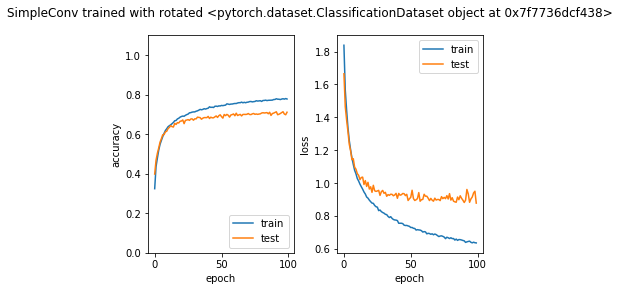

Testing both models on both datasets...


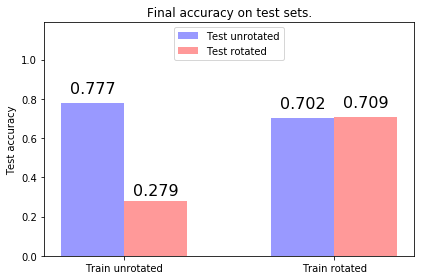

model_rotated_test_dataset score: loss=3.765909, accuracy=0.278700
model_rotated_train_dataset score: loss=3.716637, accuracy=0.290620
model_test_dataset score: loss=0.757992, accuracy=0.777100
model_train_dataset score: loss=0.206472, accuracy=0.932940
rotated_model_rotated_test_dataset score: loss=0.888936, accuracy=0.708900
rotated_model_rotated_train_dataset score: loss=0.601027, accuracy=0.789860
rotated_model_test_dataset score: loss=0.920258, accuracy=0.702300
rotated_model_train_dataset score: loss=0.655431, accuracy=0.772140


In [5]:
batch_size = 64

epochs={'cifar10':5,'mnist':2,'fashion_mnist':12,'cluttered_mnist':10,'lsa16':15,'mnist_rot':5,'pugeault':15}
from pytorch.experiment import rotation
rotated_epochs={'cifar10':100,'mnist':2,'fashion_mnist':60,'cluttered_mnist':30,'lsa16':100,'mnist_rot':5,'pugeault':40}

config=pytorch.experiment.rotation.TrainRotatedConfig(dataset_name=dataset,batch_size=batch_size,
                   epochs=epochs[dataset.name],rotated_epochs=rotated_epochs[dataset.name],
                   pre_rotated_epochs=0, optimizer=optimizer,rotated_optimizer=rotated_optimizer,
                  use_cuda=use_cuda)

scores=rotation.run(config,model,rotated_model,
                                        x_train,y_train,x_test,y_test,plot_accuracy=True,save_plots=False)
for k,v in scores.items():
    print('%s score: loss=%f, accuracy=%f' % (k,v[0],v[1]))


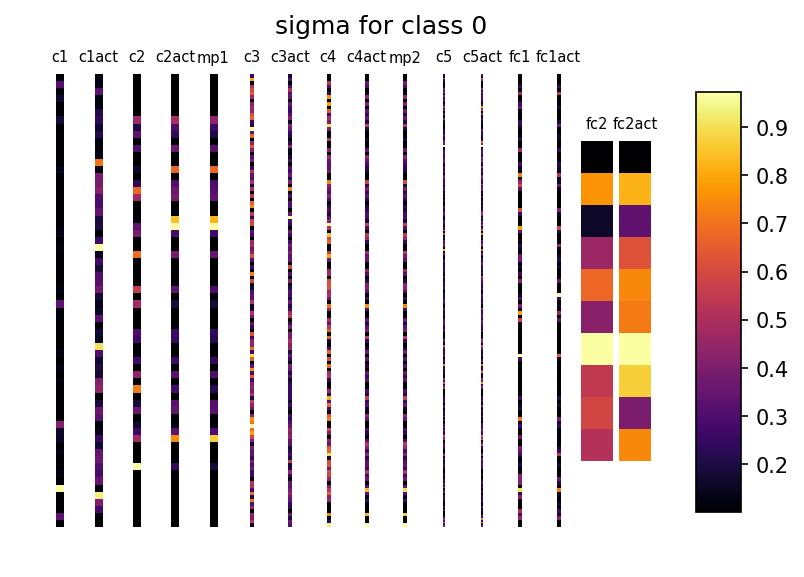

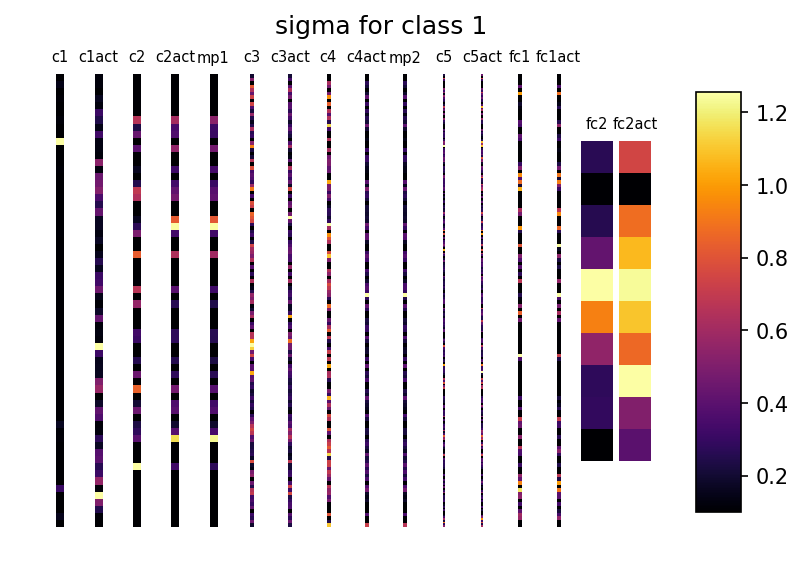

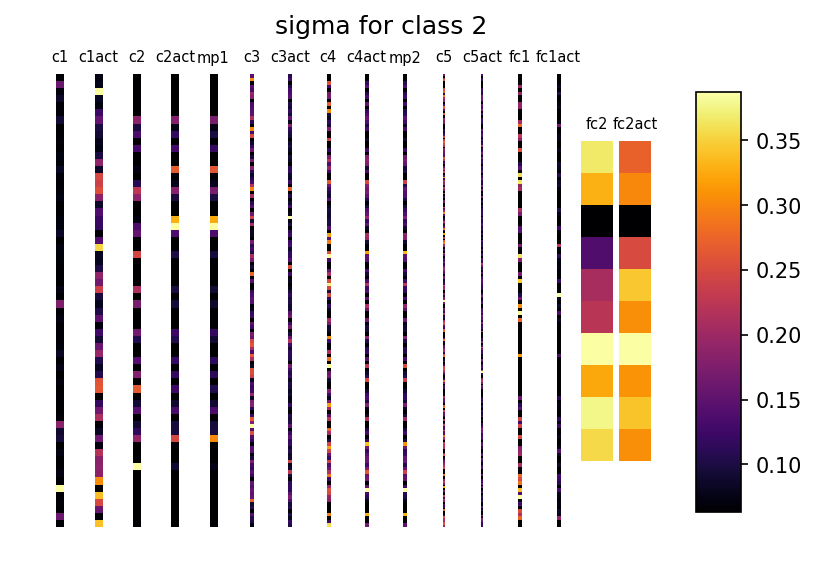

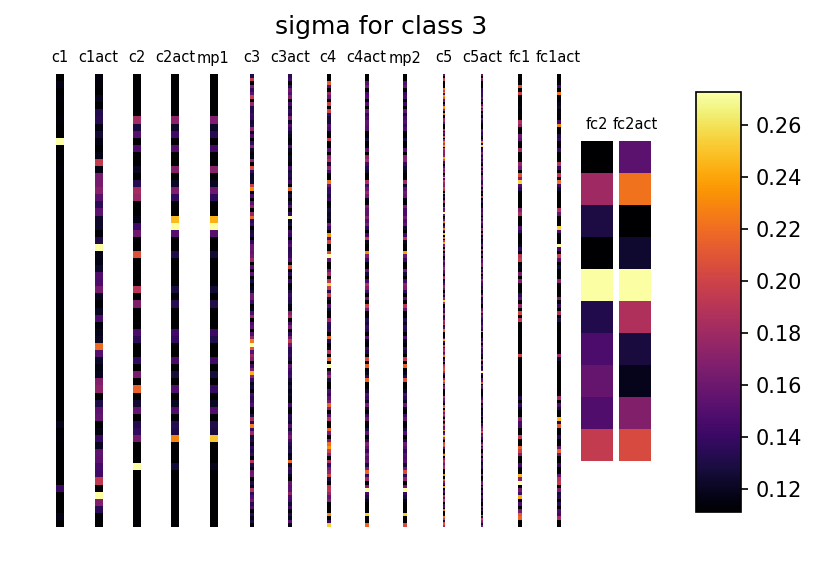

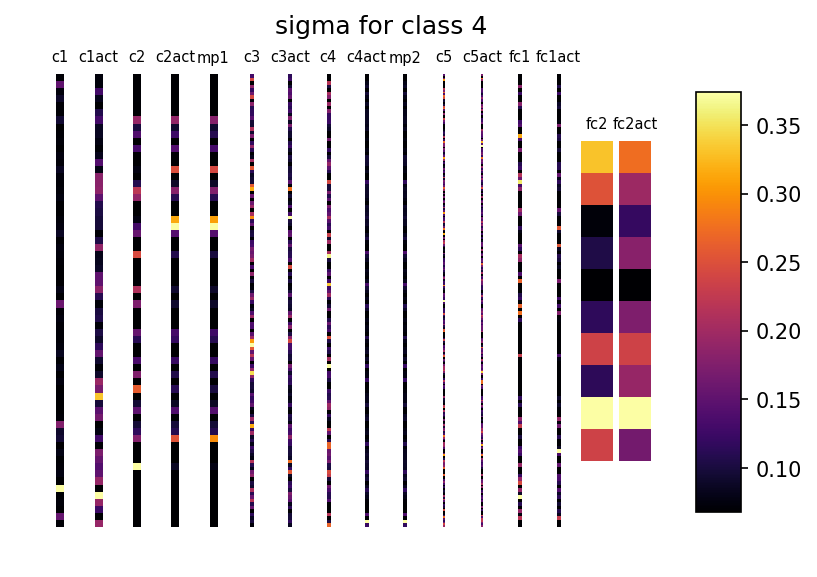

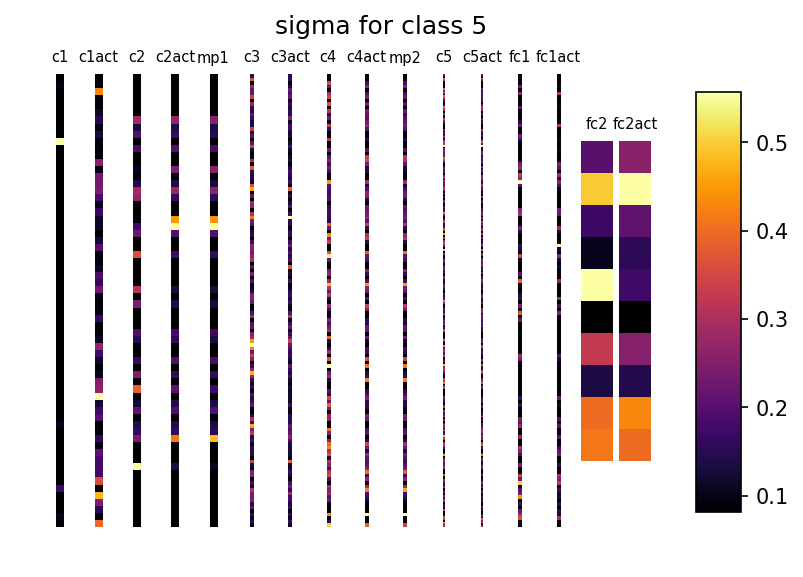

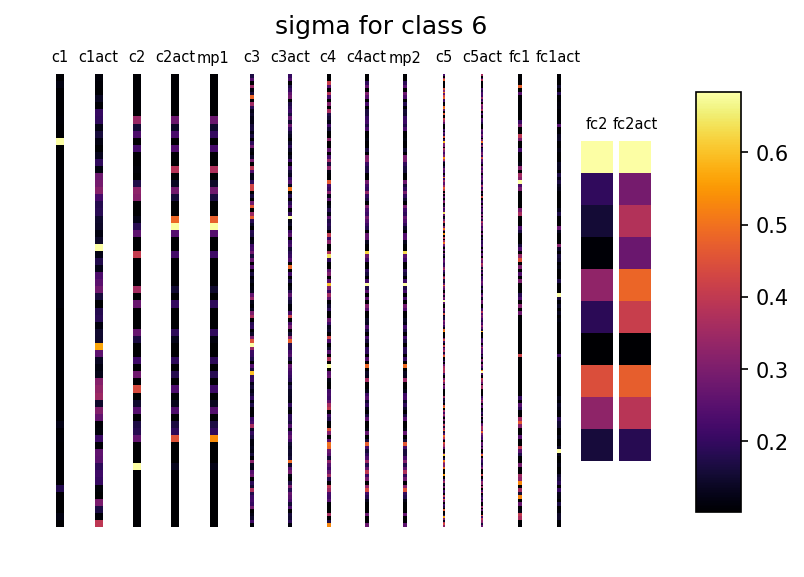

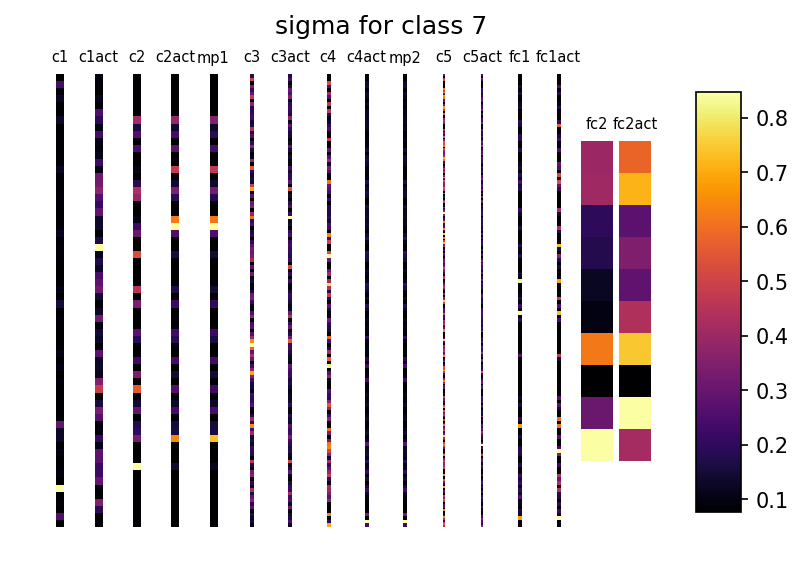

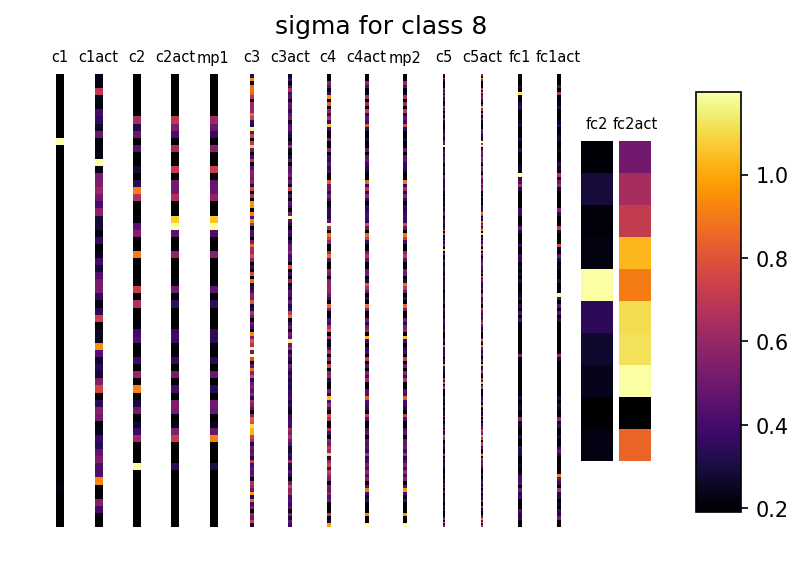

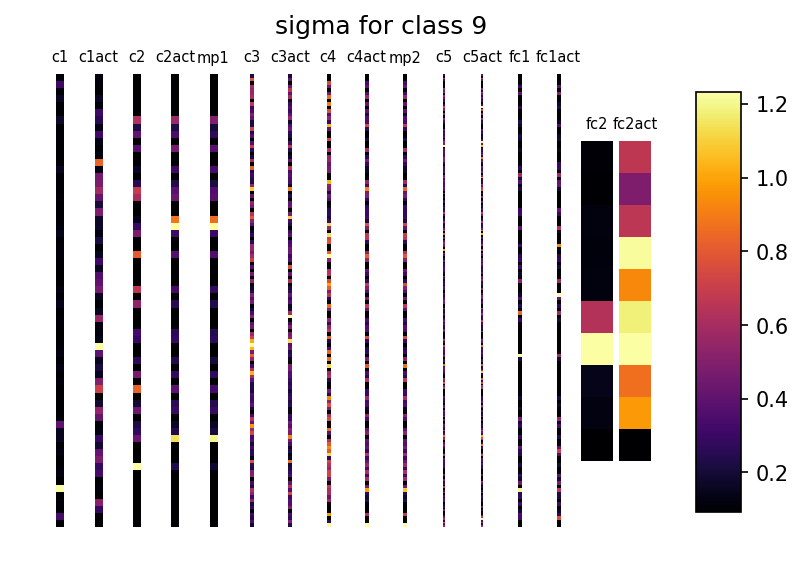

In [8]:
from pytorch.experiment import invariance
n_rotations=8

all_cvs=invariance.run(rotated_model,dataset,config,n_rotations)
invariance.plot(all_cvs,rotated_model,num_classes)

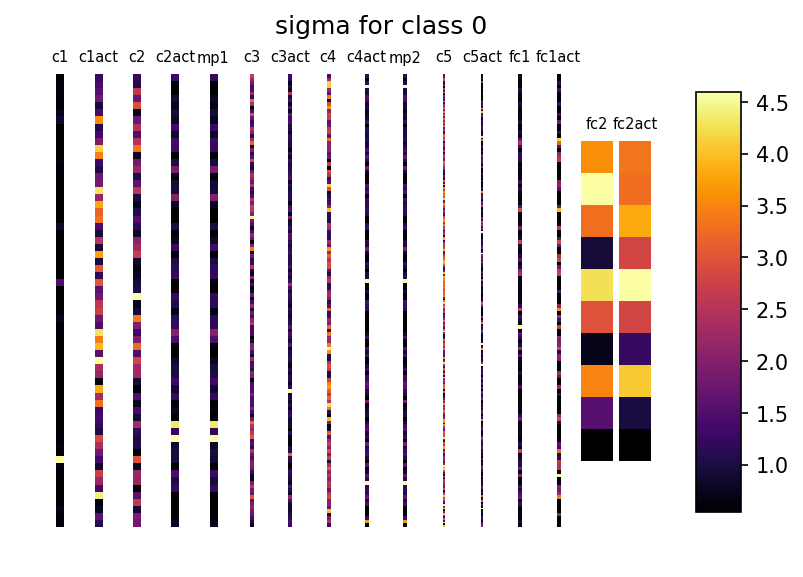

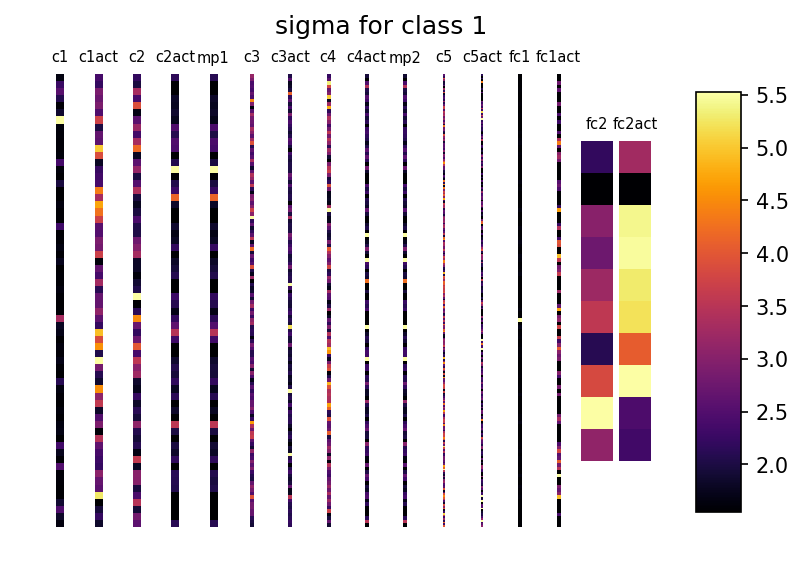

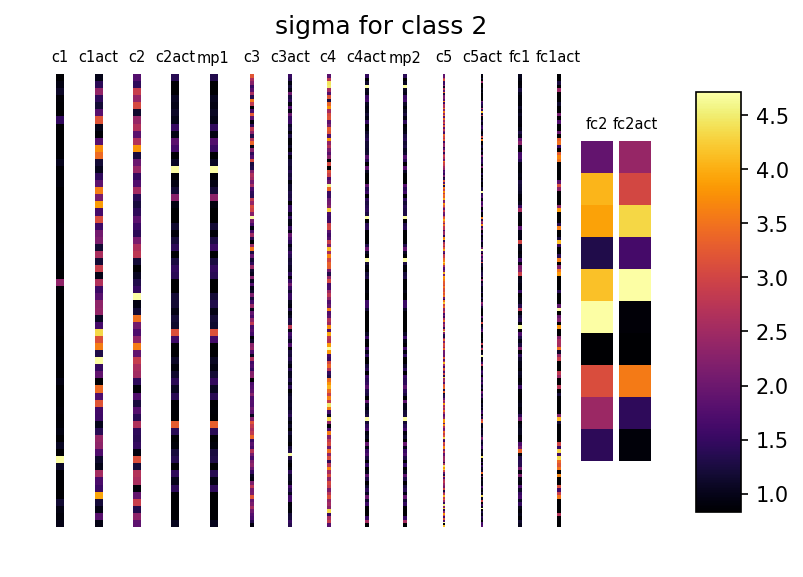

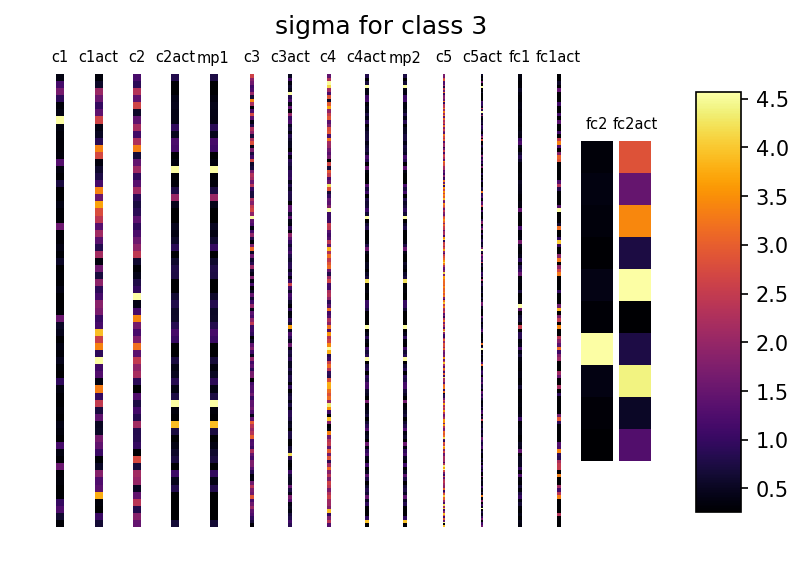

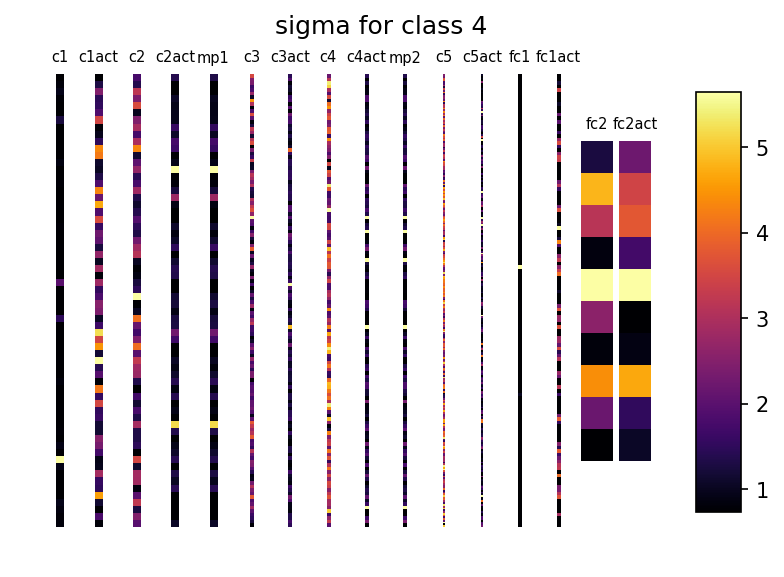

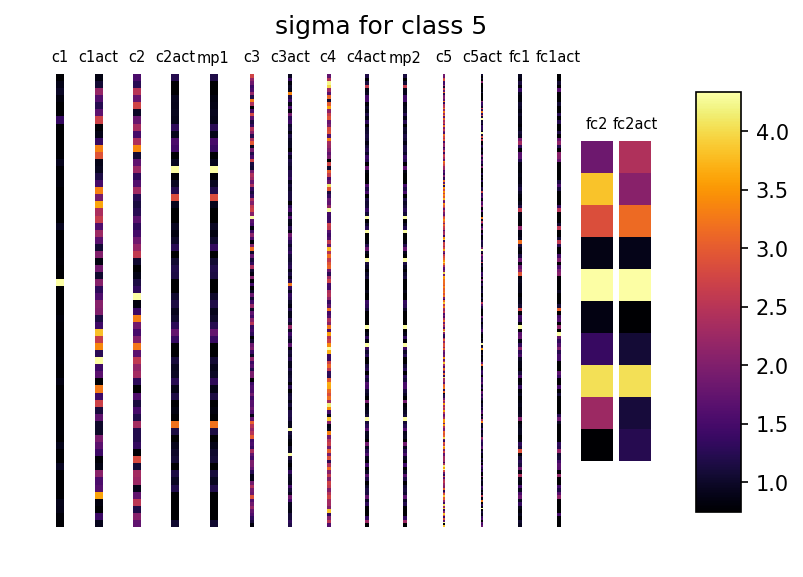

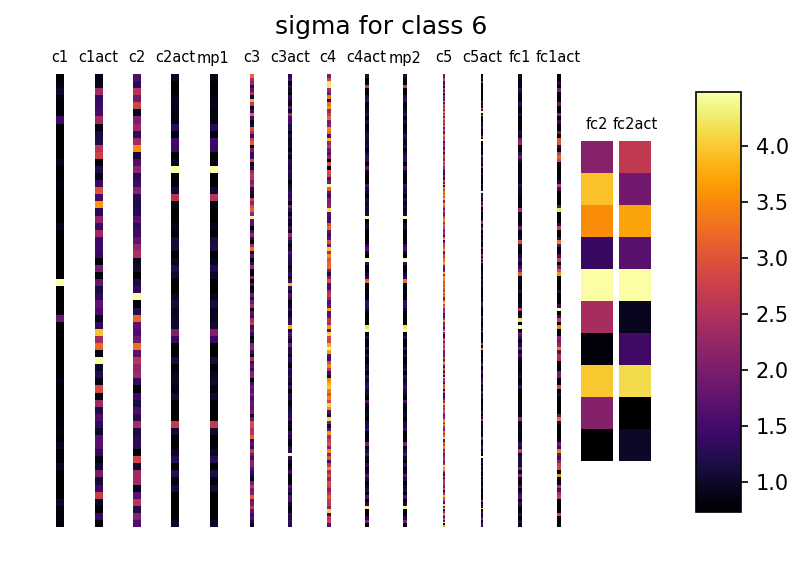

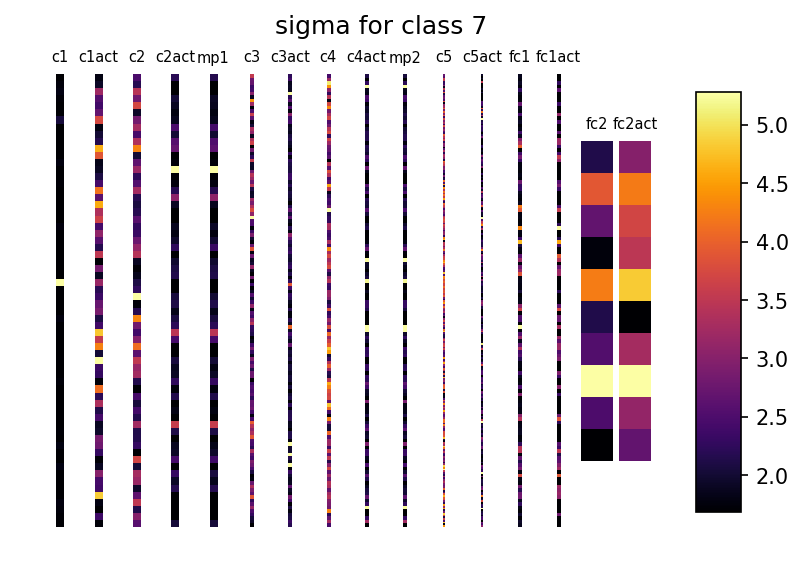

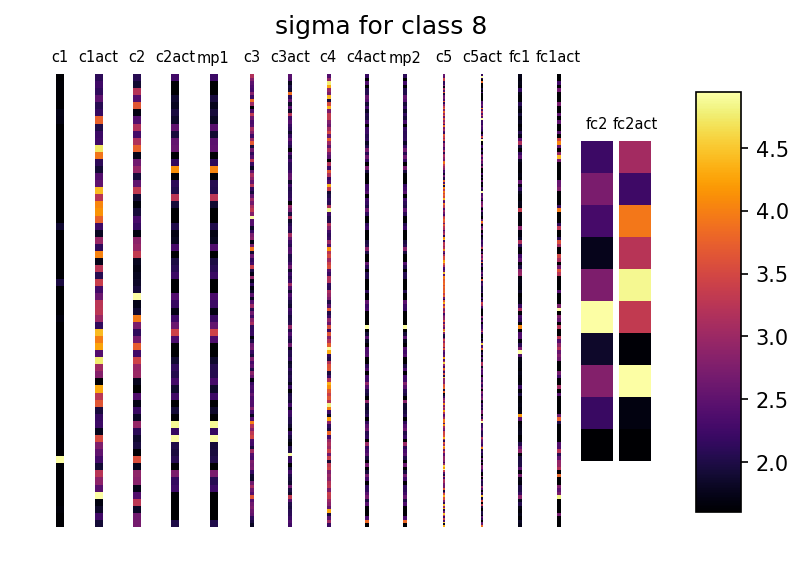

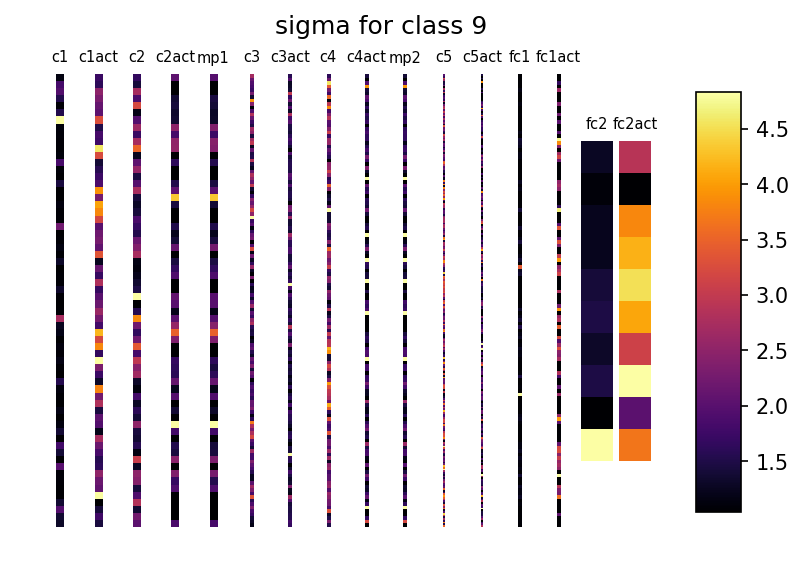

In [9]:
n_rotations=8

all_cvs=invariance.run(model,dataset,config,n_rotations)
invariance.plot(all_cvs,model,num_classes)